In [1]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
import joblib

import pandas as pd
import numpy as np
import seaborn as sns
import missingno
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from scipy.stats import zscore
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, power_transform
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [5]:
df_train = pd.read_csv("Flight_Train.csv")
df_train

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


# EDA

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [11]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,10683.0,9087.064121,4611.359167,1759.0,5277.0,8372.0,12373.0,79512.0


In [12]:
df_train.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [14]:
#To remove all the duplicate rows and checked for the row and column information
print(f"Rows and Columns before dropping duplicates: ", df_train.shape)
df_train.drop_duplicates(inplace=True)
print(f"Rows and Columns after dropping duplicates: ", df_train.shape)


Rows and Columns before dropping duplicates:  (10683, 11)
Rows and Columns after dropping duplicates:  (10463, 11)


In [15]:
#To remove all the null valued rows and checked for the row and column information.
print(f"Rows and Columns before dropping null values: ", df_train.shape)
df_train.dropna(inplace=True)
print(f"Rows and Columns after dropping null values: ", df_train.shape)

Rows and Columns before dropping null values:  (10463, 11)
Rows and Columns after dropping null values:  (10462, 11)


In [16]:
#To verify
df_train.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [17]:
#it shows the list of all the columns and the number of unique values they hold.
df_train.nunique()

Airline              12
Date_of_Journey      44
Source                5
Destination           6
Route               128
Dep_Time            222
Arrival_Time       1343
Duration            368
Total_Stops           5
Additional_Info      10
Price              1870
dtype: int64

In [18]:
#To create a function that basically separates the date info into proper numerical foramt instead of making it an obj datatype.
def date_bifurcation(df):
    df=df.copy()
    df['Date_of_Journey']=pd.to_datetime(df['Date_of_Journey'])
    df['Year_of_Journey']=df['Date_of_Journey'].dt.year
    df['Month_of_Journey']=df['Date_of_Journey'].dt.month
    df['Day_of_Journey']=df['Date_of_Journey'].dt.day
    df=df.drop(['Route', 'Date_of_Journey', 'Duration'],axis=1)
    return df

df_train = date_bifurcation(df_train)
print(f"Rows and Columns:", df_train.shape)
df_train.head()

Rows and Columns: (10462, 11)


,Airline,Source,Destination,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,Year_of_Journey,Month_of_Journey,Day_of_Journey
0,IndiGo,Banglore,New Delhi,22:20,01:10 22 Mar,non-stop,No info,3897,2019,3,24
1,Air India,Kolkata,Banglore,05:50,13:15,2 stops,No info,7662,2019,1,5
2,Jet Airways,Delhi,Cochin,09:25,04:25 10 Jun,2 stops,No info,13882,2019,9,6
3,IndiGo,Kolkata,Banglore,18:05,23:30,1 stop,No info,6218,2019,12,5
4,IndiGo,Banglore,New Delhi,16:50,21:35,1 stop,No info,13302,2019,1,3


In [19]:
#same way ,here we are creating a function that deals with the separation on timings for arrival and departure.
def time_bifurcation(df):
    df['Departure_hour']=pd.to_datetime(df['Dep_Time']).dt.hour
    df['Departure_minute']=pd.to_datetime(df['Dep_Time']).dt.minute
    df=df.drop(['Dep_Time'],axis=1)
    df['Arrival_hour']=pd.to_datetime(df['Arrival_Time']).dt.hour
    df['Arrival_minute']=pd.to_datetime(df['Arrival_Time']).dt.minute
    df=df.drop(['Arrival_Time'],axis=1)
    return df

df_train = time_bifurcation(df_train)
print(f"Rows and Columns:", df_train.shape)
df_train.head()

Rows and Columns: (10462, 13)


,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Year_of_Journey,Month_of_Journey,Day_of_Journey,Departure_hour,Departure_minute,Arrival_hour,Arrival_minute
0,IndiGo,Banglore,New Delhi,non-stop,No info,3897,2019,3,24,22,20,1,10
1,Air India,Kolkata,Banglore,2 stops,No info,7662,2019,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,2 stops,No info,13882,2019,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,1 stop,No info,6218,2019,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,1 stop,No info,13302,2019,1,3,16,50,21,35


In [ ]:
df_train.drop("Year_of_Journey", axis=1, inplace=True)

# Visualization

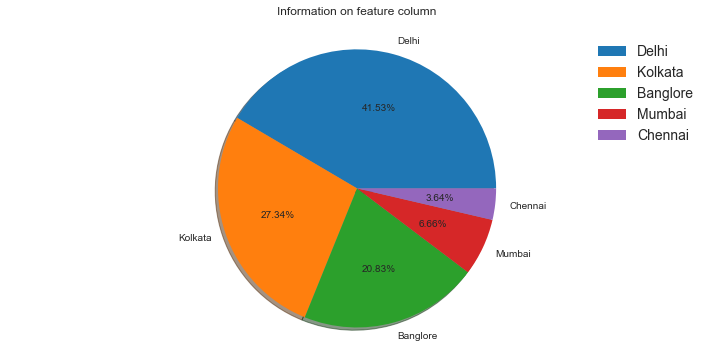

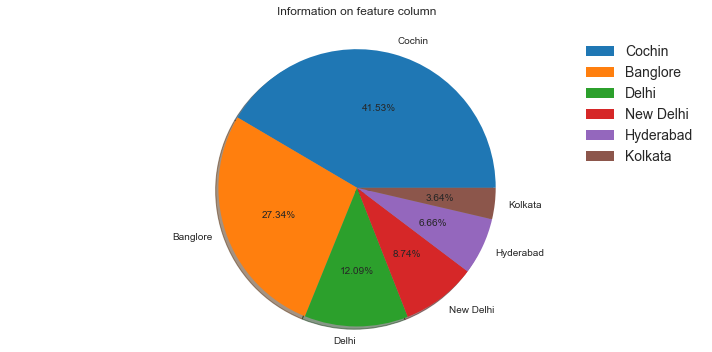

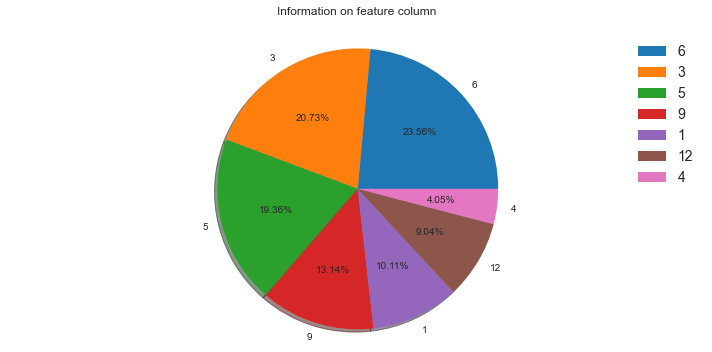

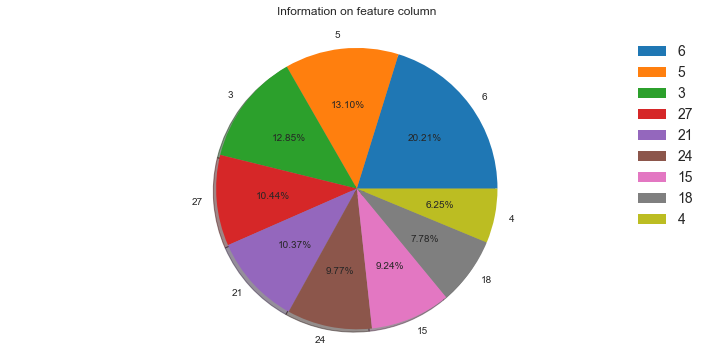

In [23]:
def generate_pie(x):
    plt.style.use('seaborn-white')
    plt.figure(figsize=(10,5))
    plt.pie(x.value_counts(), labels=x.value_counts().index, shadow=True, autopct='%1.2f%%')
    plt.legend(prop={'size':14})
    plt.axis('equal')
    plt.title('Information on feature column\n')
    plt.tight_layout()
    return plt.show()

generate_pie(df_train['Source'])
generate_pie(df_train['Destination'])
generate_pie(df_train['Month_of_Journey'])
generate_pie(df_train['Day_of_Journey'])

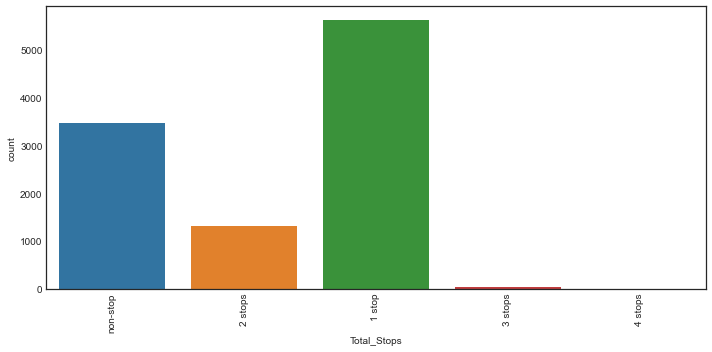

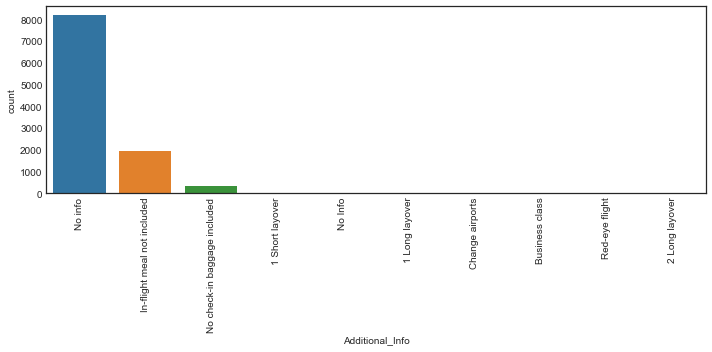

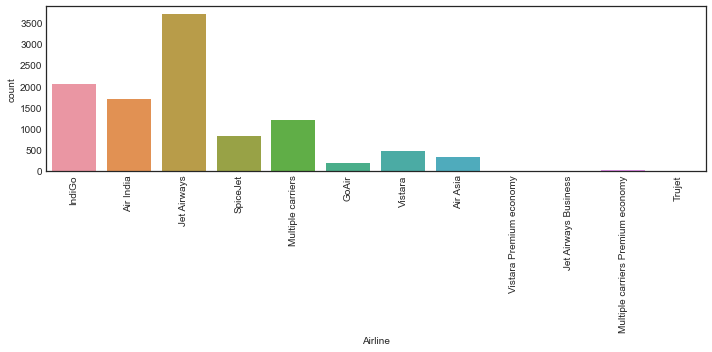

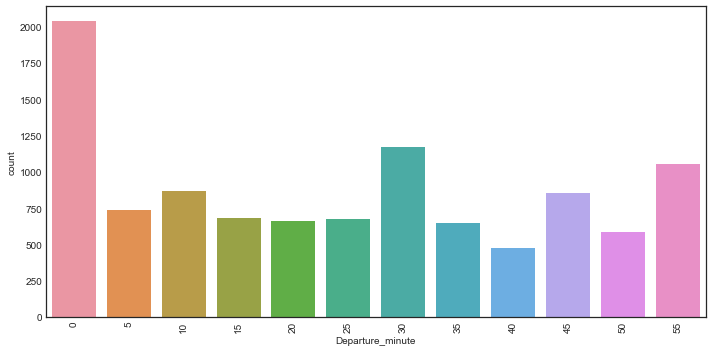

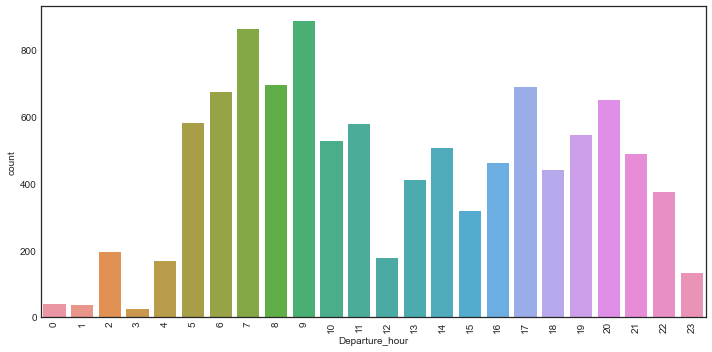

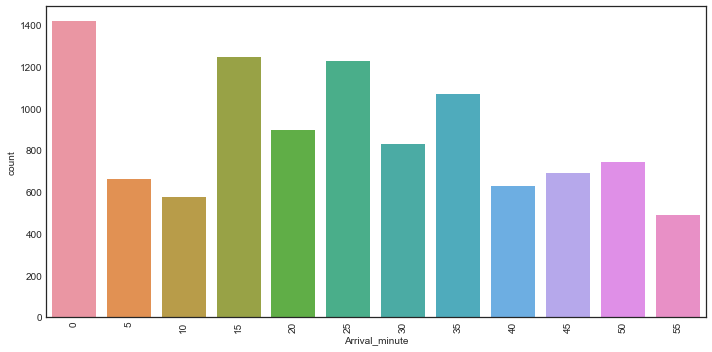

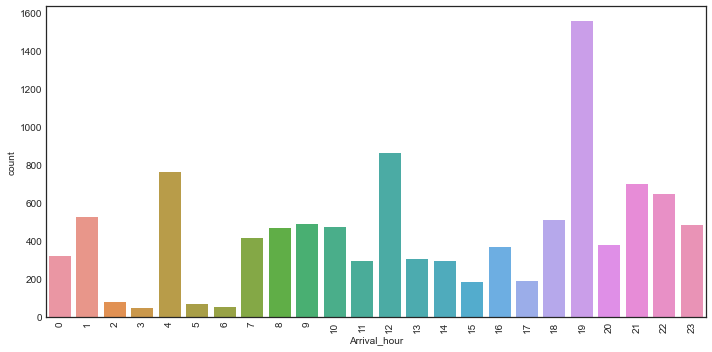

In [24]:
def generate_countplot(x):
    plt.figure(figsize=(10,5))
    sns.countplot(x)
    plt.xticks(rotation=90)
    plt.tight_layout()
    return plt.show()

generate_countplot(df_train['Total_Stops'])
generate_countplot(df_train['Additional_Info'])
generate_countplot(df_train['Airline'])
generate_countplot(df_train['Departure_minute'])
generate_countplot(df_train['Departure_hour'])
generate_countplot(df_train['Arrival_minute'])
generate_countplot(df_train['Arrival_hour'])

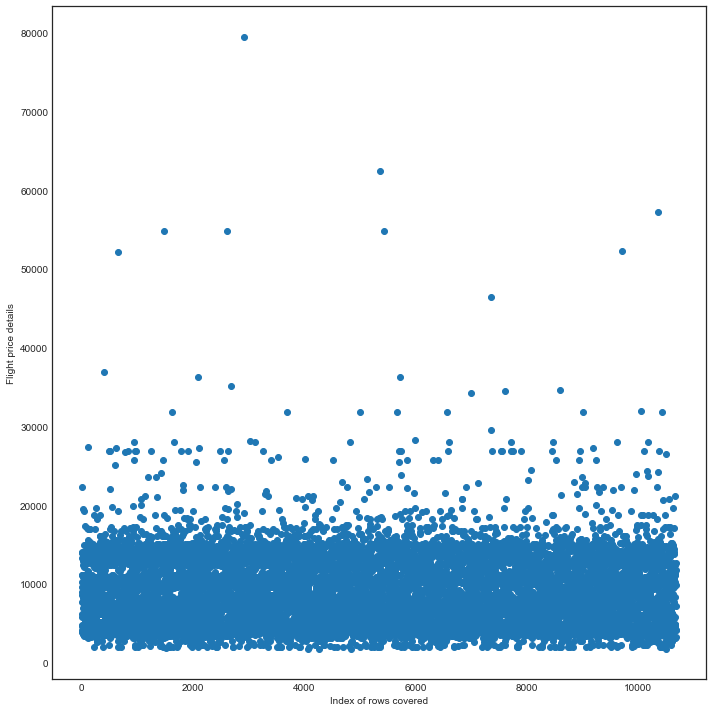

In [25]:
plt.style.use('fast')
plt.figure(figsize=(10,10))
plt.scatter(df_train.index, df_train['Price'])
plt.xlabel("Index of rows covered")
plt.ylabel("Flight price details")
plt.tight_layout()
plt.show()


<AxesSubplot:xlabel='Source', ylabel='Price'>

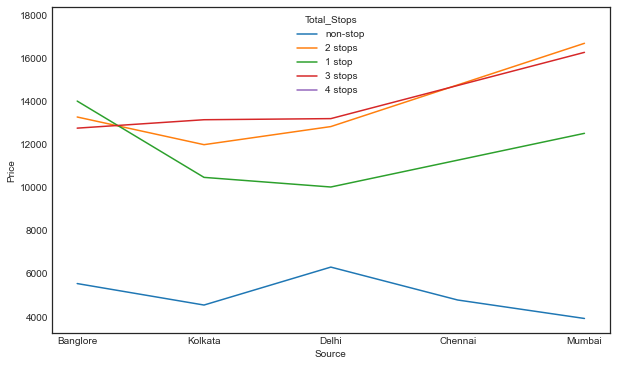

In [26]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Source', y='Price', hue='Total_Stops', data=df_train, ci=None)

non stop flights have lower price irrespective of the source as compared to flights that have 1 or more than 1 stops in the fligh haul.

<AxesSubplot:xlabel='Destination', ylabel='Price'>

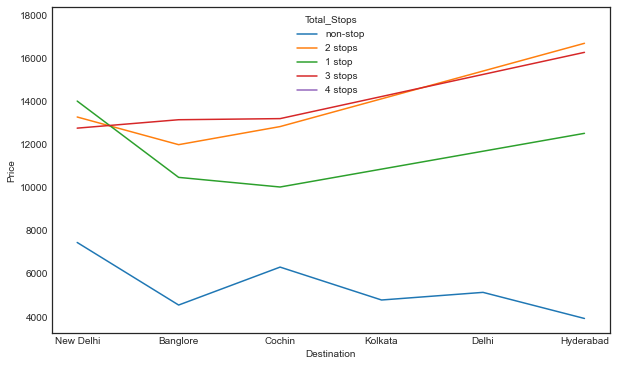

In [27]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Destination', y='Price', hue='Total_Stops', data=df_train, ci=None)

non stop flights have lower price irrespective of the destination as compared to flights that have 1 or more than 1 stops in the fligh haul.

<AxesSubplot:xlabel='Month_of_Journey', ylabel='Price'>

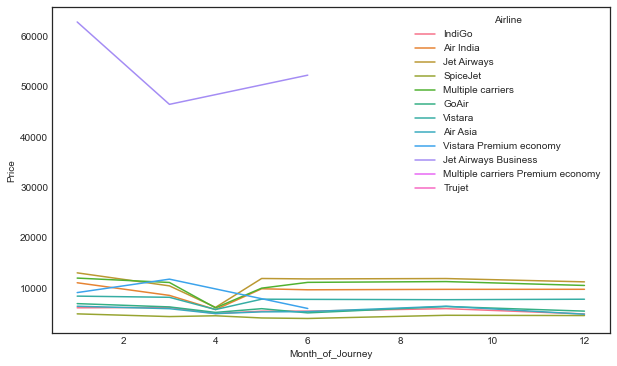

In [28]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Month_of_Journey', y='Price', hue='Airline', data=df_train, ci=None)

we can see that Jet Airways Business class has the highest price than the rest possibly because the remaining offer the economy class data.

<AxesSubplot:xlabel='Day_of_Journey', ylabel='Price'>

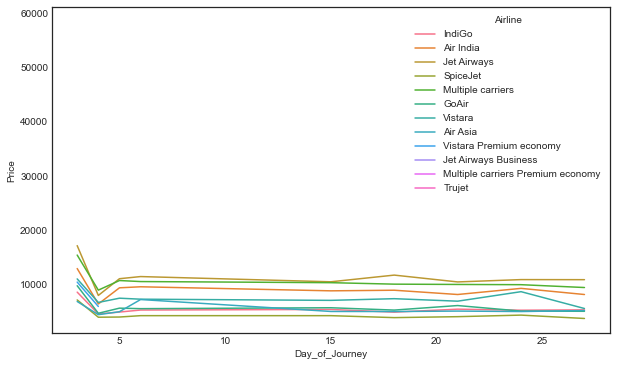

In [29]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Day_of_Journey', y='Price', hue='Airline', data=df_train, ci=None)

All the airlines have high price between 1-5 days of a month and that reduces a bit on rest of the days apart from them.

<AxesSubplot:xlabel='Departure_minute', ylabel='Price'>

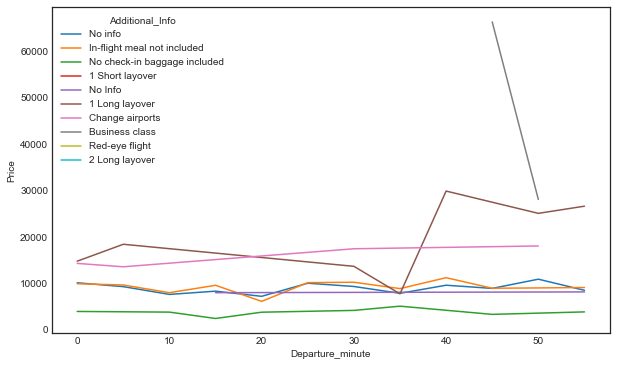

In [30]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Departure_minute', y='Price', hue='Additional_Info', data=df_train, ci=None)

Business class has high price and has data coverage for departure minutes between 45-50 minutes roughly

<AxesSubplot:xlabel='Departure_hour', ylabel='Price'>

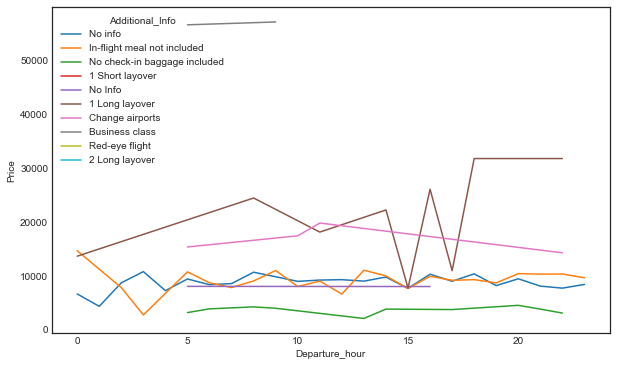

In [31]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Departure_hour', y='Price', hue='Additional_Info', data=df_train, ci=None)

Business class has high price and it's departure hour is between 5-10 but the second highest pricing is for 1 long layover type with spike in between 17-22 departure hour

<AxesSubplot:xlabel='Arrival_minute', ylabel='Price'>

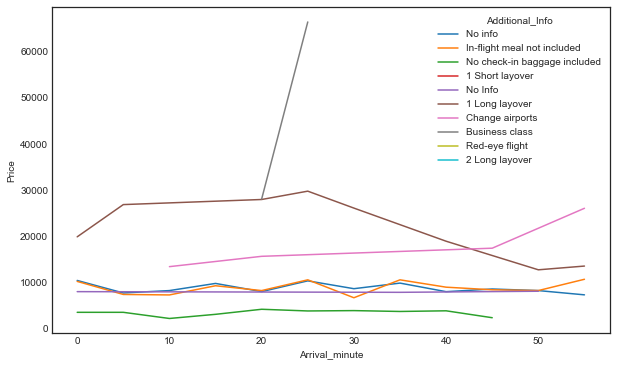

In [32]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Arrival_minute', y='Price', hue='Additional_Info', data=df_train, ci=None)

Business class again has an exponential price rise and the arrival minutes mostly range between 20-30 minutes

<AxesSubplot:xlabel='Arrival_hour', ylabel='Price'>

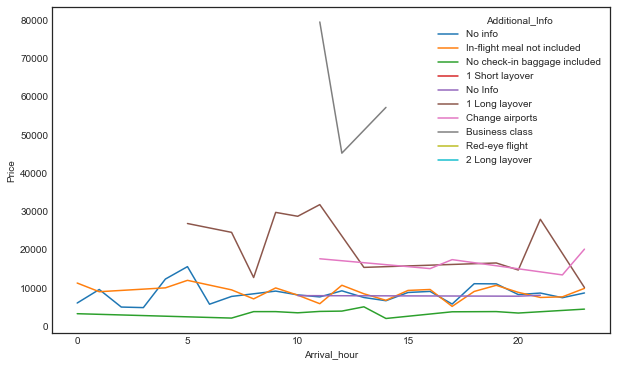

In [33]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Arrival_hour', y='Price', hue='Additional_Info', data=df_train, ci=None)

we see that price for no check-in bag included is least as compared to the business class being highest and the arrival hour for business class is spread only between 10-15 minutes

# Encoding

In [35]:
#Encoding the categorical object datatype columns
oe=OrdinalEncoder()
def ordinal_encoder(df, col):
    df[col]=oe.fit_transform(df[col])
    return df

df_train=ordinal_encoder(df_train,['Airline', 'Source', 'Destination', 'Total_Stops', 'Additional_Info'])

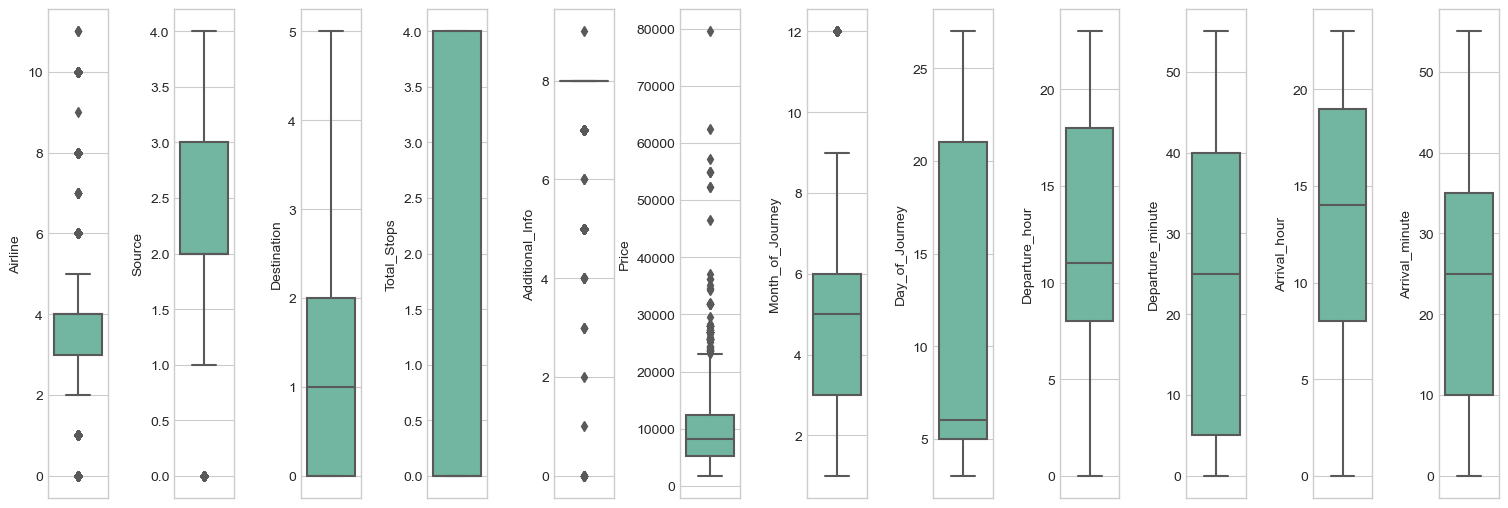

In [36]:
#To check the presence of outliers 
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(ncols=12, nrows=1, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in df_train.items():
    sns.boxplot(y=col, data=df_train, ax=ax[index], palette="Set2")
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

The outliers are present in our dataset but since all of the feature columns are categorical data we will not have to worry about the presence of outliers here.

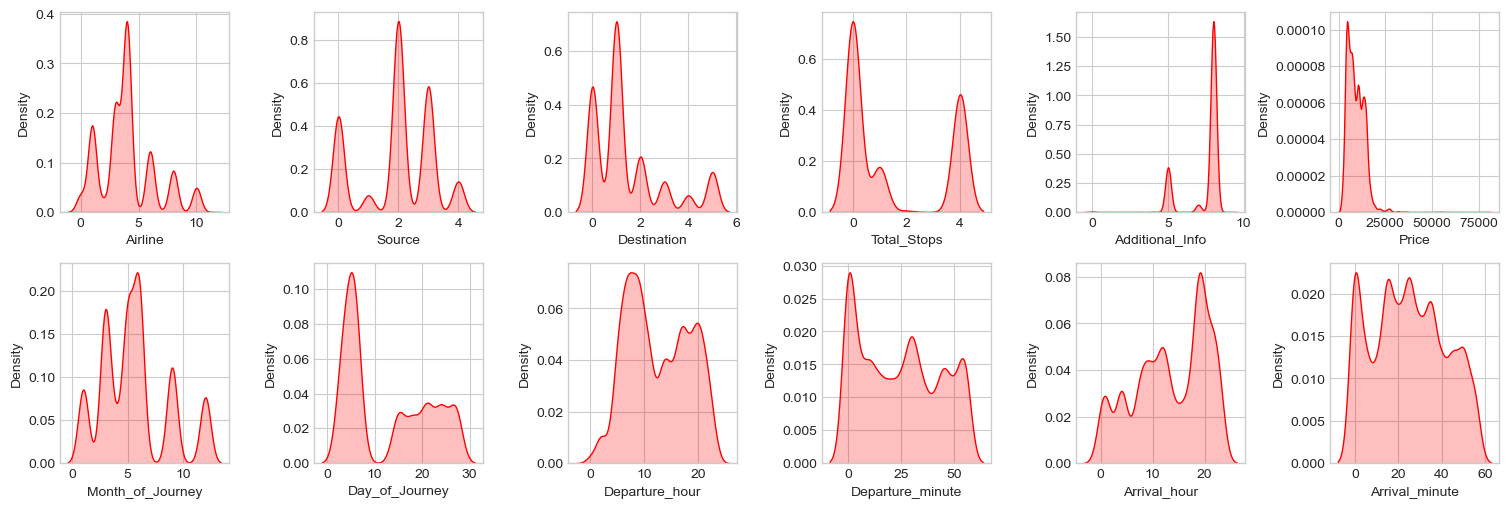

In [37]:
#To check the skewness 
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in df_train.items():
    sns.distplot(value, ax=ax[index], hist=False, color="r", kde_kws={"shade": True})
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

# Correlation

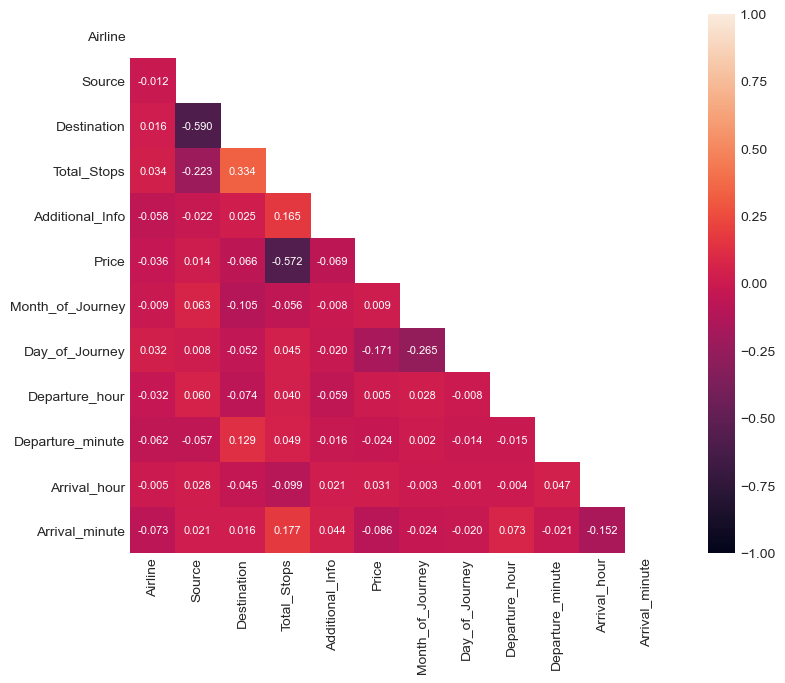

In [40]:
plt.style.use('seaborn-pastel')
upper_triangle = np.triu(df_train.corr())
plt.figure(figsize=(10,7))
sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True, square=True, fmt='0.3f', 
            annot_kws={'size':8}, mask=upper_triangle)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


Correlation details between our label and feature and also amongst our labels.

# Splitting and Scaling

In [41]:
X = df_train.drop('Price', axis=1)
Y = df_train['Price']


I have separated the dataset into features and label where X represents all the feature columns and Y represents the regression target label column.

In [42]:
#Feaature scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Month_of_Journey,Day_of_Journey,Departure_hour,Departure_minute,Arrival_hour,Arrival_minute
0,-0.414916,-1.646877,2.404213,1.392916,0.497963,-0.846221,1.293326,1.662578,-0.234123,-1.807045,-0.888367
1,-1.260756,0.882057,-0.972012,-0.254274,0.497963,-1.513956,-0.867922,-1.305841,1.360364,-0.056554,-0.586611
2,0.008004,0.039079,-0.296767,-0.254274,0.497963,1.156984,-0.754172,-0.607390,0.031625,-1.369422,0.016902
3,-0.414916,0.882057,-0.972012,-0.803337,0.497963,2.158586,-0.867922,0.964126,-1.031367,1.402189,0.318658
4,-0.414916,-1.646877,2.404213,-0.803337,0.497963,-1.513956,-1.095422,0.614900,1.360364,1.110440,0.620415


StandardScaler method is used to normalize my feature values and ensure that my regression model does not have any kind of biasness towards a particular column value.

In [44]:
#finding the best random state for building Regression Models
maxAccu=0
maxRS=0

for i in range(1, 1000):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=i)
    lr=LinearRegression()
    lr.fit(X_train, Y_train)
    pred = lr.predict(X_test)
    r2 = r2_score(Y_test, pred)
    
    if r2>maxAccu:
        maxAccu=r2
        maxRS=i

print("Best R2 score is", maxAccu,"on Random State", maxRS)

Best R2 score is 0.4194390126695826 on Random State 754


In [45]:
# Machine learning model for regression with Evaluation metrics
# Regression Model Function

def reg(model, X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=754)
    
    # Training the model
    model.fit(X_train, Y_train)
    
    # Predicting Y_test
    pred = model.predict(X_test)
    
    # RMSE - a lower RMSE score is better than a higher one
    rmse = mean_squared_error(Y_test, pred, squared=False)
    print("RMSE Score :", rmse)
    
    # R2 score
    r2 = r2_score(Y_test, pred, multioutput='variance_weighted')*100
    print("R2 Score :", r2)
    
    # Cross Validation Score
    cv_score = (cross_val_score(model, X, Y, cv=5).mean())*100
    print("Cross Validation Score:", cv_score)
    
    # Result of r2 score minus cv score
    result = r2 - cv_score
    print("R2 Score - Cross Validation Score :", result)

In [46]:
# Linear Regression Model

model=LinearRegression()
reg(model, X, Y)

RMSE Score : 3253.2452134994414
R2 Score : 41.94390126695826
Cross Validation Score: 37.028436757605974
R2 Score - Cross Validation Score : 4.915464509352283


In [47]:
# Ridge Regression

model=Ridge(alpha=1e-2, normalize=True)
reg(model, X, Y)


RMSE Score : 3252.094541183132
R2 Score : 41.98496286977021
Cross Validation Score: 37.025024097422346
R2 Score - Cross Validation Score : 4.959938772347861


In [48]:
# Lasso Regression

model=Lasso(alpha=1e-2, normalize=True, max_iter=1e5)
reg(model, X, Y)

RMSE Score : 3253.0465046164677
R2 Score : 41.950993207130836
Cross Validation Score: 37.028435460972034
R2 Score - Cross Validation Score : 4.922557746158802


In [49]:
# Random Forest Regressor

model=RandomForestRegressor(max_depth=2, max_features="sqrt")
reg(model, X, Y)

RMSE Score : 3029.2263730171503
R2 Score : 49.664115069575544
Cross Validation Score: 44.924607165959706
R2 Score - Cross Validation Score : 4.739507903615838


In [50]:
# Gradient Boosting Regressor

model=GradientBoostingRegressor(loss='quantile', n_estimators=200, max_depth=5)
reg(model, X, Y)

RMSE Score : 2504.9919133120343
R2 Score : 65.5787287179685
Cross Validation Score: 67.67804172312314
R2 Score - Cross Validation Score : -2.0993130051546416


In [51]:
# Ada Boost Regressor

model=AdaBoostRegressor(n_estimators=300, learning_rate=1.05, random_state=42)
reg(model, X, Y)


RMSE Score : 3066.187569306349
R2 Score : 48.42827158308161
Cross Validation Score: 32.32037483858014
R2 Score - Cross Validation Score : 16.107896744501467


In [52]:
# XGB Regressor

model=XGBRegressor()
reg(model, X, Y)

RMSE Score : 1408.8013601931516
R2 Score : 89.11286083744568
Cross Validation Score: 89.31337098569448
R2 Score - Cross Validation Score : -0.20051014824879587


In [53]:
# LGBM Regressor

model=LGBMRegressor()
reg(model, X, Y)

RMSE Score : 1386.5943462397358
R2 Score : 89.45338482387285
Cross Validation Score: 86.38669818049202
R2 Score - Cross Validation Score : 3.0666866433808337


# Hyperparamter tuning

In [55]:
# Choosing XGB Regressor

fmod_param = {'booster' : ['gbtree','dart','gblinear'],
              'importance_type' : ['gain','split'],
              'n_estimators' : [100,200,500],
              'eta' : [0.001, 0.01, 0.1]
             }

I have chosen the XGB regressor as my best model since it is able to provide me the highest R2 score plus the model is doing better in Cross validation score

In [56]:
GSCV = GridSearchCV(XGBRegressor(), fmod_param, cv=5)

In [57]:
GSCV.fit(X_train,Y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [58]:
GSCV.best_params_


{'booster': 'dart', 'eta': 0.1, 'importance_type': 'gain', 'n_estimators': 500}

In [59]:
Final_Model = XGBRegressor(booster='dart', eta=0.1, importance_type='gain', n_estimators=500)
Classifier = Final_Model.fit(X_train, Y_train)
fmod_pred = Final_Model.predict(X_test)
fmod_r2 = r2_score(Y_test, fmod_pred)*100
print("R2 score for the Best Model is:", fmod_r2)

R2 score for the Best Model is: 87.55683252006776


In [60]:
filename = "FinalModel_FPP01.pkl"
joblib.dump(Final_Model, filename)

['FinalModel_FPP01.pkl']

In [62]:

df_test = pd.read_csv("flight_test.csv")
df_test

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info
...,...,...,...,...,...,...,...,...,...,...
2666,Air India,6/06/2019,Kolkata,Banglore,CCU → DEL → BLR,20:30,20:25 07 Jun,23h 55m,1 stop,No info
2667,IndiGo,27/03/2019,Kolkata,Banglore,CCU → BLR,14:20,16:55,2h 35m,non-stop,No info
2668,Jet Airways,6/03/2019,Delhi,Cochin,DEL → BOM → COK,21:50,04:25 07 Mar,6h 35m,1 stop,No info
2669,Air India,6/03/2019,Delhi,Cochin,DEL → BOM → COK,04:00,19:15,15h 15m,1 stop,No info


In [63]:
df_test.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

In [64]:
print(f"Rows and Columns before dropping duplicates: ", df_test.shape)
df_test.drop_duplicates(inplace=True)
print(f"Rows and Columns after dropping duplicates: ", df_test.shape)

Rows and Columns before dropping duplicates:  (2671, 10)
Rows and Columns after dropping duplicates:  (2645, 10)


In [65]:
df_test = date_bifurcation(df_test)
print(f"Rows and Columns:", df_test.shape)
df_test.head()

Rows and Columns: (2645, 10)


,Airline,Source,Destination,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Year_of_Journey,Month_of_Journey,Day_of_Journey
0,Jet Airways,Delhi,Cochin,17:30,04:25 07 Jun,1 stop,No info,2019,6,6
1,IndiGo,Kolkata,Banglore,06:20,10:20,1 stop,No info,2019,12,5
2,Jet Airways,Delhi,Cochin,19:15,19:00 22 May,1 stop,In-flight meal not included,2019,5,21
3,Multiple carriers,Delhi,Cochin,08:00,21:00,1 stop,No info,2019,5,21
4,Air Asia,Banglore,Delhi,23:55,02:45 25 Jun,non-stop,No info,2019,6,24


In [66]:
df_test = time_bifurcation(df_test)
print(f"Rows and Columns:", df_test.shape)
df_test.head()

Rows and Columns: (2645, 12)


,Airline,Source,Destination,Total_Stops,Additional_Info,Year_of_Journey,Month_of_Journey,Day_of_Journey,Departure_hour,Departure_minute,Arrival_hour,Arrival_minute
0,Jet Airways,Delhi,Cochin,1 stop,No info,2019,6,6,17,30,4,25
1,IndiGo,Kolkata,Banglore,1 stop,No info,2019,12,5,6,20,10,20
2,Jet Airways,Delhi,Cochin,1 stop,In-flight meal not included,2019,5,21,19,15,19,0
3,Multiple carriers,Delhi,Cochin,1 stop,No info,2019,5,21,8,0,21,0
4,Air Asia,Banglore,Delhi,non-stop,No info,2019,6,24,23,55,2,45


In [67]:
df_test.drop("Year_of_Journey", axis=1, inplace=True)
df_test=ordinal_encoder(df_test, ['Airline', 'Source', 'Destination', 'Total_Stops', 'Additional_Info'])

In [68]:
df_test = pd.DataFrame(scaler.fit_transform(df_test), columns=df_test.columns)

In [69]:
predited_values = Final_Model.predict(df_test)
data = pd.DataFrame(predited_values, columns=['Predicted Flight Prices'])
data

,Predicted Flight Prices
0,14110.669922
1,4543.466309
2,12488.573242
3,10740.701172
4,3604.916504
...,...
2640,10002.468750
2641,4299.227539
2642,16538.347656
2643,12429.273438
